In [189]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

np.random.seed(11)

In [190]:
"""Dataset generation"""

def shuffle_dataset(X, y):
    """Shuffles X and Y together."""
    y = np.expand_dims(y, axis=-1)
    fused = np.hstack((X, y))
    np.random.shuffle(fused)
    sep_x, sep_y = fused[:, :-1], fused[:, -1]
    return sep_x, sep_y

def generate_normal_dataset(mean, variance, num_features=13, num_instances=1026):
  X = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_instances, num_features))

  # Generate Y according to a linear classification boundary
  rand_weights = np.random.uniform(low=mean-5, high=mean+5, size=num_features)

  y = np.dot(X, rand_weights) > np.mean(np.dot(X, rand_weights))
  y = y.astype(int)
  num_zeros = (y == 0).sum()
  num_ones = (y == 1).sum()
  print(f"Number of 1s: {num_ones}; Number of 0s: {num_zeros}")
  return X, y


In [191]:
# Create synthetic dataset
SPLITS = 4

# Create splits
X_splits = []
y_splits = []
normal_means = []
normal_variances = []
for idx in range(SPLITS):
  # Choose random parameters for Gaussian distribution
  mean = np.random.uniform(low=-5, high=5)
  variance = np.random.uniform(low=0, high=3)
  normal_means.append(mean)
  normal_variances.append(variance)
  print(f"Split number {idx}: mean {mean} variance {variance}")

  # Generate random dataset
  X, y = generate_normal_dataset(mean, variance)

  # Save dataset into splits
  X_splits.append(X)
  y_splits.append(y)


Split number 0: mean -3.197303111232308 variance 0.05842572446287375
Number of 1s: 507; Number of 0s: 519
Split number 1: mean 1.5172848342579224 variance 1.8094205323554475
Number of 1s: 508; Number of 0s: 518
Split number 2: mean 3.7206200533552867 variance 2.3380414317305265
Number of 1s: 512; Number of 0s: 514
Split number 3: mean 3.1019449428889256 variance 0.16530703487464993
Number of 1s: 513; Number of 0s: 513


In [192]:
"""Statistics for full model"""

X_full = np.concatenate(X_splits)
y_full = np.concatenate(y_splits)
X_full, y_full = shuffle_dataset(X_full, y_full)

full_model = LogisticRegression(solver='lbfgs', max_iter=100000)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)
full_model.fit(X_train, y_train)

predict_y = full_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predict_y)}")

probas = full_model.predict_proba(X_test)[:, 1]
full_model_auc = roc_auc_score(y_test, probas)
print(f"ROC AUC: {full_model_auc}")

Accuracy: 0.6224116930572473
ROC AUC: 0.6648618482765172


In [193]:
def train_model(X, y, eval_instances_ratio=0.2, show_split_eval=True):
  # Calculate eval instances

  assert len(X) == len(y)
  eval_instances = int(np.ceil(len(X) * eval_instances_ratio))

  # Shuffle dataset and create eval splits
  X, y = shuffle_dataset(X, y)
  train_x, eval_x = X[:eval_instances], X[-eval_instances:]
  train_y, eval_y = y[:eval_instances], y[-eval_instances:]

  # Train model
  model = LogisticRegression(solver='lbfgs', max_iter=100000)
  model.fit(train_x, train_y)
  coef = model.coef_
  intercept = model.intercept_
  classes = model.classes_

  # Show stats on current split
  if show_split_eval:
      temp_model = LogisticRegression(solver='lbfgs', max_iter=100000)
      temp_model.fit(train_x, train_y)
      predict_y = temp_model.predict(eval_x)
      probas = temp_model.predict_proba(eval_x)[:, 1]
      temp_model_auc = roc_auc_score(eval_y, probas)
      print(f"Accuracy: {accuracy_score(eval_y, predict_y)}; ROC AUC: {temp_model_auc}")

  return coef, intercept, classes, model, eval_x, eval_y


In [194]:
"""Train each split model"""

coefs, intercepts, evals_x, evals_y, split_models = [] , [] , [], [], []
classes = None

for i in range(SPLITS):
  X = X_splits[i]
  y = y_splits[i]
  print(f"Split {i} eval statistics")
  coef, intercept, classes, model, eval_x, eval_y = train_model(X, y)
  coefs.append(coef)
  intercepts.append(intercept)
  evals_x.append(eval_x)
  evals_y.append(eval_y)
  split_models.append(model)

  classes = classes


agg_model = LogisticRegression()

# Equal average aggreation and intercepts of model weights
avg_agg_coefs = np.sum(np.sum(coefs, axis=1), axis=0) / (SPLITS)
avg_agg_intercepts = np.array(np.sum(intercepts) / SPLITS)

agg_model.coef_ = avg_agg_coefs.reshape(1, 13)
agg_model.intercept_ = avg_agg_intercepts.reshape(1,)
agg_model.classes_ = classes

# Concatentate evaluation X and y
eval_X = np.concatenate(evals_x)
eval_y = np.concatenate(evals_y)
eval_X, eval_y = shuffle_dataset(eval_X, eval_y)

score = agg_model.score(eval_X, eval_y)
print(f"Aggregate model acc score: {score}")

probas = agg_model.predict_proba(eval_X)[:, 1]
agg_model_auc = roc_auc_score(eval_y, probas)
print(f"ROC AUC for agg model: {agg_model_auc}")

split_AUCs = []
for idx, model in enumerate(split_models):
  probas = model.predict_proba(eval_X)[:, 1]
  auc = roc_auc_score(eval_y, probas)
  print(f"Split number {idx+1}: {auc}")
  split_AUCs.append(auc)

print(f"Average split AUCs: {np.mean(split_AUCs)}")

Split 0 eval statistics
Accuracy: 0.9563106796116505; ROC AUC: 0.9938708156529938
Split 1 eval statistics
Accuracy: 0.9757281553398058; ROC AUC: 0.9972623430567356
Split 2 eval statistics
Accuracy: 0.970873786407767; ROC AUC: 0.9955693815987934
Split 3 eval statistics
Accuracy: 0.970873786407767; ROC AUC: 0.9959866220735787
Aggregate model acc score: 0.5109223300970874
ROC AUC for agg model: 0.5767492028314953
Split number 1: 0.5065571161655753
Split number 2: 0.5862680725909597
Split number 3: 0.5395106770480305
Split number 4: 0.5583362312348598
Average split AUCs: 0.5476680242598563


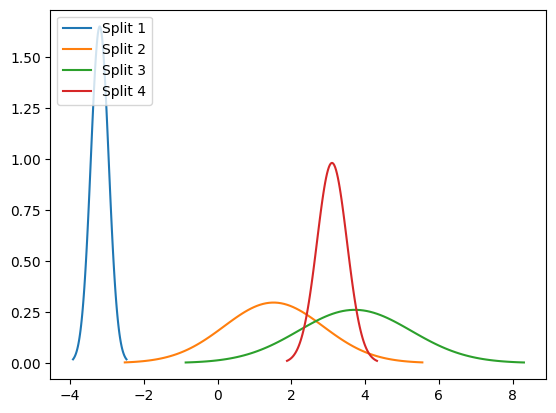

In [195]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

for idx in range(len(normal_means)):
  mean = normal_means[idx]
  sd = np.sqrt(normal_variances[idx])
  x = np.linspace(mean - 3*sd, mean + 3*sd, 100)
  plt.plot(x, norm.pdf(x, mean, sd), label=f"Split {idx+1}")

plt.legend(loc="upper left")
plt.show()

0.6648618482765172
0.5767492028314953
[0.5065571161655753, 0.5862680725909597, 0.5395106770480305, 0.5583362312348598]


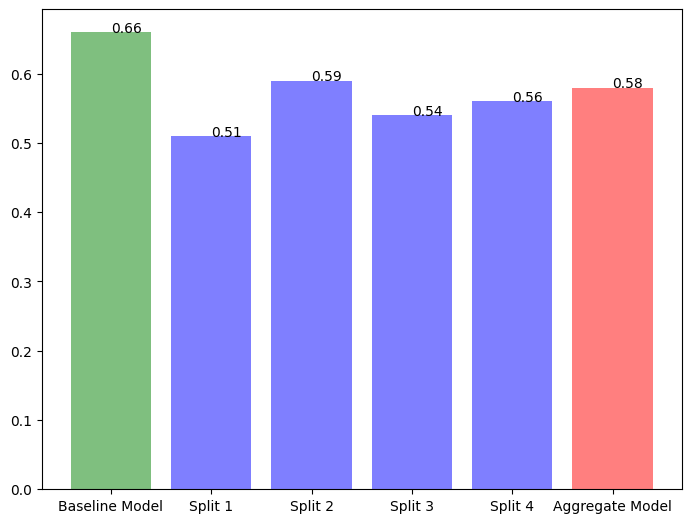

In [196]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

print(full_model_auc)
print(agg_model_auc)
print(split_AUCs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Baseline Model', 'Split 1', 'Split 2', 'Split 3', 'Split 4', 'Aggregate Model']
aucs = [full_model_auc] + split_AUCs + [agg_model_auc]
aucs = [round(auc, 2) for auc in aucs]
addlabels(labels, aucs)
ax.bar(labels,aucs, color=["green", "blue", "blue", "blue", "blue", "red"], alpha=0.5)
plt.show()